**Importar bibliotecas**

In [1]:
import os,flopy, sys, platform
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
from seaborn import load_dataset
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
from pynverse import inversefunc
from scipy.interpolate import InterpolatedUnivariateSpline

flopy is installed in C:\Users\Jerson\miniconda3\lib\site-packages\flopy


**MODELO DE FLUJO**

**Cargar Resultados del Modelo de Flujo**

In [2]:
model_ws='../4_OUT/R_SIM_KRIG'
modelname='Modelo_Flujo'
exe_name= '../1_SOLVER/mf2005.exe'
mf = flopy.modflow.Modflow.load(modelname+'.nam', exe_name=exe_name, model_ws=model_ws)

**Cargas Hidráulicas horizontal**

In [3]:
headobj = bf.HeadFile(model_ws + '/'+ modelname + '.hds')
times = headobj.get_times()
cbb = bf.CellBudgetFile(model_ws + '/'+ modelname + '.cbc')
for iplot, time in enumerate(times):
    head = headobj.get_data(totim=time)
    #Extract flow right face and flow front face
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
    flf = cbb.get_data(text='FLOW LOWER FACE', totim=time)[0]   

**MODELO DE TRANSPORTE**

**Cargar Resultados del Modelo de Transporte**

In [4]:
namemt3d='transModel'
mt_model = flopy.mt3d.Mt3dms.load(namemt3d+'.nam',  model_ws=model_ws, version='mt3d-usgs',
                                  exe_name='../1_SOLVER/mt3d-usgs_1.1.0_64.exe', modflowmodel=mf)

In [5]:
fname = os.path.join(model_ws +'/'+'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_alldata()
fname = os.path.join(model_ws +'/'+'MT3D001.MAS')
mvt = mt_model.load_mas(fname)

**Suma de concentracion de contaminante en los diversos tiempos de observacion**

In [6]:
suma=[]
for h in range(0,15):
    for k in range (0,30):
        C=(conc[h,k,0,:])
        a=[]
        for i in C:
            if i >= 0:
                a.append(i)
        b=np.sum(a)
        suma.append(b)  
#suma
#len(suma)
#times

In [7]:
t_1=np.sum(suma[0:30])
t_2=np.sum(suma[30:60])-100*29
t_3=np.sum(suma[60:90])-100*29
t_4=np.sum(suma[90:120])
t_5=np.sum(suma[120:150])
t_6=np.sum(suma[150:180])
t_7=np.sum(suma[180:210])
t_8=np.sum(suma[210:240])
t_9=np.sum(suma[240:270])
t_10=np.sum(suma[270:300])
t_11=np.sum(suma[300:330])
t_12=np.sum(suma[330:360])
t_13=np.sum(suma[360:390])
t_14=np.sum(suma[390:420])
t_15=np.sum(suma[420:450])
t=[t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14, t_15]
t

[0.0,
 9.090911865234375,
 1684.7817687988281,
 1735.3930912017822,
 1999.11228179932,
 1838.7526875019553,
 1846.4610614776611,
 1655.9594631195068,
 699.8018146469258,
 426.3119636523561,
 92.4480636622691,
 6.590101655011313e-05,
 2.0482469556365616e-07,
 4.637136348999796e-13,
 1.2191255615900719e-24]

**Principales estadisticas de la muestra**

In [8]:

#redondeo de tiempos que superan la masa maxima suministrada debido a errores en la solucion
t_ok=[]
for i in t:
    if i > t_4:
        i = t_4
    t_ok.append(i)
#t_ok   
m=np.mean(t_ok)
ma=np.max(t_ok)
mi=np.min(t_ok)
std=np.std(t_ok)

a = "Mean = {:.2f}".format(m)
b = "Máx = {:.2f}".format(ma)
c = "Mín = {:.2f}".format(mi)
#d = "Std = {:.2f}".format(de)
e=[a,b,c]
#t_ok

**Calculo de concentraciones a distintas distancias**

In [9]:
suma_DIST=[]
for z in [10,20,30,40,50,60,70,80,90]:
    for h in range(0,15):
        a_0=[]
        for k in range (0,30):
            C=(conc[h,k,0,1:z])
            a=[]
            for i in C:
                if i > -1e+30:
                    a.append(i)
            b=np.sum(a)
            a_0.append(b)
        b_1=np.sum(a_0)
        suma_DIST.append(b_1)
        #Suma_DIST

s_100=suma_DIST[0:15]
s_200=suma_DIST[15:30]
s_300=suma_DIST[30:45]
s_400=suma_DIST[45:60]
s_500=suma_DIST[60:75]
s_600=suma_DIST[75:90]
s_700=suma_DIST[90:105]
s_800=suma_DIST[105:120]
s_900=suma_DIST[120:135]
DIST=[s_100,s_200,s_300,s_400,s_500,s_600,s_700,s_800,s_900]
#DIST

**Calculo de masa que pasa por el punto de control**

In [10]:
paso=[]
for y in [s_100,s_200,s_300,s_400,s_500,s_600,s_700,s_800,s_900]:
    for i in y:
        a=t_4-i
        if a > 0:
            paso.append(a)
        else:
            a=0
            paso.append(a)
        
p_100=paso[0:15]
p_200=paso[15:30]
p_300=paso[30:45]
p_400=paso[45:60]
p_500=paso[60:75]
p_600=paso[75:90]
p_700=paso[90:105]
p_800=paso[105:120]
p_900=paso[120:135]

for y in [p_100,p_200,p_300,p_400,p_500,p_600,p_700,p_800,p_900]:
    for i in range (0,4):
        y[i]=0
a_0=[p_100,p_200,p_300,p_400,p_500,p_600,p_700,p_800,p_900]
np.savetxt(model_ws+'/'+'Curvas_Kriging.txt',a_0,fmt='%18e')

#p_200
#a_0

**Acumulado de masa que pasa**

In [11]:
h=[]
for y in [p_100,p_200,p_300,p_400,p_500,p_600,p_700,p_800,p_900]:
    a=0
    for i in y:
        a = a + i
        h.append(a)

In [12]:
amasa_ac=h[0:15]#9
bmasa_ac=h[15:30]#19
cmasa_ac=h[30:45]#29
dmasa_ac=h[45:60]#39
emasa_ac=h[60:75]#49
fmasa_ac=h[75:90]#59
gmasa_ac=h[90:105]#69
hmasa_ac=h[105:120]#79
imasa_ac=h[120:135]#89
a_1=[amasa_ac,bmasa_ac,cmasa_ac,dmasa_ac,emasa_ac,fmasa_ac,gmasa_ac,hmasa_ac,imasa_ac]
#print(a_1)

**Pasar a dataframe los resultados**

In [13]:
times_y=[]
for i in range(0,15):
    b = times[i]/(86400*365)
    times_y.append(b)
#times_y
tiempo_des=times_y

lista_prom = list(zip(tiempo_des,p_100,p_200,p_300,p_400,p_500,p_600,
                     p_700,p_800,p_900))
ship_columns_prom = ['Tiempo','Conc Prom (g) X = 100','Masa (g) X = 200','Masa (g) X = 300','Masa (g) X = 400',
                    'Masa (g) X = 500','Masa (g) X = 600','Masa (g) X = 700','Masa (g) X = 800','Masa (g) X = 900'
                    ]
#times_y

In [14]:
Krig_R = pd.DataFrame(columns=ship_columns_prom, data=lista_prom)
#escribir los resutlados en un fichero excel
#WB_resumen.to_csv(model_ws + '/' + wb_name +'_PromedioAnual.csv')
#path = '../4_OUT/R_SIM/CONCENTRACIONES_Py.xlsx'
#book = load_workbook(path)
#writer_C = pd.ExcelWriter(path,engine = 'openpyxl')
#writer_C.book = book
#Krig_R.to_excel(writer_C,sheet_name='KRIGING')
#writer_C.save()
#writer_C.close()
Krig_R

,Tiempo,Conc Prom (g) X = 100,Masa (g) X = 200,Masa (g) X = 300,Masa (g) X = 400,Masa (g) X = 500,Masa (g) X = 600,Masa (g) X = 700,Masa (g) X = 800,Masa (g) X = 900
0,3.170979e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.424658e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.739729e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.013699e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.369863e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2.465753e-01,609.655578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,4.931507e-01,1142.562509,642.450903,316.111683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1.000000e+00,1646.241617,1187.686232,852.611670,676.199184,618.443283,554.693661,521.757038,429.576130,187.606350
8,3.002061e+00,1735.363265,1686.323833,1667.714805,1629.716144,1345.400112,1172.527462,1113.195949,1090.307825,1066.122586
9,5.003488e+00,1735.392526,1730.593999,1693.166662,1689.985259,1688.721927,1659.812479,1566.011874,1398.650833,1335.042616


**Grafico de suministro de contaminante**

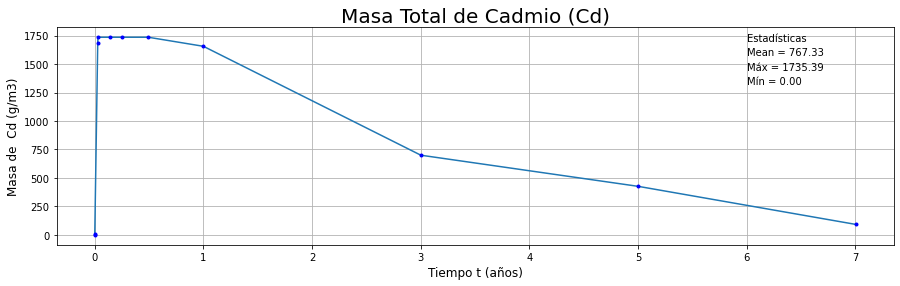

In [15]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(times_y[0:11], t_ok[0:11], label='Prom Acu Con Cd', marker="o", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
plt.title('Distribucion Temporal de la Masa Total de Cadmio (Cd)',fontsize=20)
plt.xlabel('Tiempo t (años)',fontsize=12)
plt.ylabel('Masa de  Cd (g/m3)',fontsize=12)
a1=6
b1=1700
b2=125
plt.text(a1, b1,"Estadísticas")
plt.text(a1, b1-b2, e[0])
plt.text(a1, b1-2*b2, e[1])
plt.text(a1, b1-3*b2, e[2])
plt.grid()
plt.show()

**Grafica de concentraciones a distintas distancias**

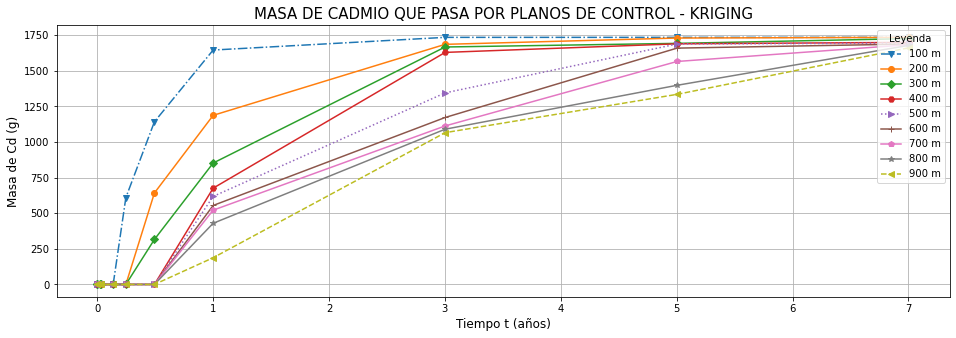

In [29]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
b_1=0
b_2=11
plt.plot(times_y[b_1:b_2],p_100[b_1:b_2], label='100 m',linestyle='-.', marker="v")
plt.plot(times_y[b_1:b_2],p_200[b_1:b_2], label='200 m',marker="o")
plt.plot(times_y[b_1:b_2],p_300[b_1:b_2], label='300 m',marker="D")
plt.plot(times_y[b_1:b_2],p_400[b_1:b_2], label='400 m',marker="H")
plt.plot(times_y[b_1:b_2],p_500[b_1:b_2], label='500 m',linestyle=':',marker=">")
plt.plot(times_y[b_1:b_2],p_600[b_1:b_2], label='600 m',marker="+")
plt.plot(times_y[b_1:b_2],p_700[b_1:b_2], label='700 m',marker="p")
plt.plot(times_y[b_1:b_2],p_800[b_1:b_2], label='800 m',marker="*")
plt.plot(times_y[b_1:b_2],p_900[b_1:b_2], label='900 m',linestyle='--',marker="<")
#v=[times_y[b_1],times_y[b_2-1],p_900[b_1],2500]
#plt.axis(v)
plt.title('MASA DE CADMIO QUE PASA POR PLANOS DE CONTROL - KRIGING',fontsize=15)
plt.xlabel('Tiempo t (años)',fontsize=12)
plt.ylabel('Masa de Cd (g)',fontsize=12)
plt.legend(title='Leyenda',loc=1)
plt.grid()
plt.show()


**Grafica Promedio y Promedio Acumulado de concentracion de cadmio**

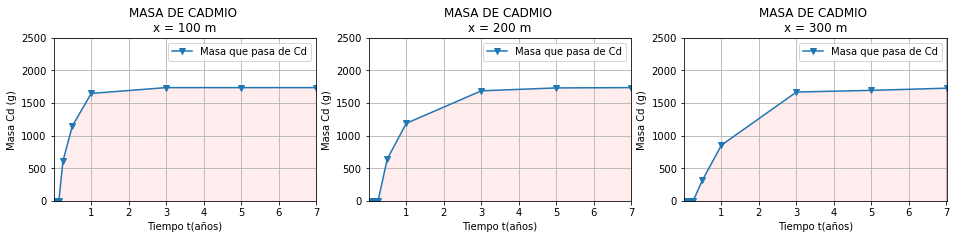

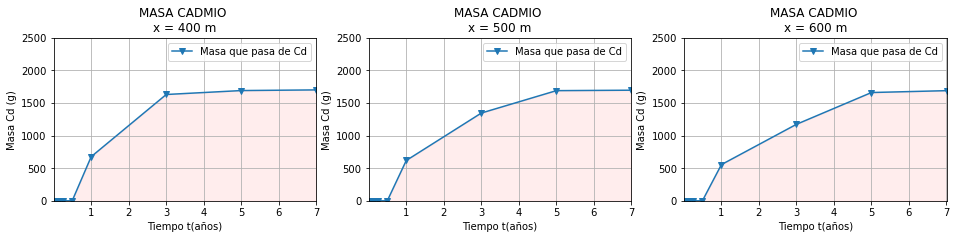

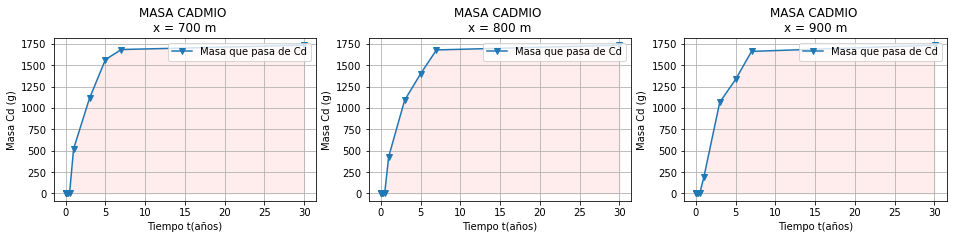

In [17]:
fig = plt.figure(figsize=(16,3))

for j in range (0,3):
    ax = fig.add_subplot(1, 3, j+1)
    #plt.plot(times_y[0:11],a_1[j][0:11], label='Masa Acu Cd', marker="o", markersize="2", markeredgewidth="2",
             #markerfacecolor="b", markeredgecolor="b")
    plt.plot(times_y[0:11],a_0[j][0:11], label='Masa que pasa de Cd',marker="v")
    plt.title('MASA DE CADMIO \nx = {} m'.format((j+1)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1)
    plt.fill_between(times_y[0:11], a_0[j][0:11],color='red', alpha=0.07)
    plt.grid()
    v=[times_y[b_1],times_y[b_2-1],p_900[b_1],2500]
    plt.axis(v)
fig = plt.figure(figsize=(16,3))
for j in range (0,3):
    ax = fig.add_subplot(1, 3, j+1)
    #plt.plot(times_y[0:11],a_1[j+3][0:11], label='Prom Acu Con Cd', marker="o", markersize="2", markeredgewidth="2",
             #markerfacecolor="b", markeredgecolor="b")
    plt.plot(times_y[0:11],a_0[j+3][0:11], label='Masa que pasa de Cd',marker="v")
    plt.title('MASA CADMIO \nx = {} m'.format((j+4)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1)
    plt.fill_between(times_y[0:11], a_0[j+3][0:11],color='red', alpha=0.07)
    plt.grid()
    v=[times_y[b_1],times_y[b_2-1],p_900[b_1],2500]
    plt.axis(v)
fig = plt.figure(figsize=(16,3))
for j in range (0,3):
    ax = fig.add_subplot(1, 3, j+1)
    #plt.plot(times_y[0:12],a_1[j+6][0:12], label='Prom Acu Con Cd', marker="o", markersize="2", markeredgewidth="2",
             #markerfacecolor="b", markeredgecolor="b")
    plt.plot(times_y[0:12],a_0[j+6][0:12], label='Masa que pasa de Cd',marker="v")
    plt.title('MASA CADMIO \nx = {} m'.format((j+7)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1)
    plt.fill_between(times_y[0:12], a_0[j+6][0:12],color='red', alpha=0.07)
    plt.grid()
    #v=[times_y[0],times_y[12-1],p_900[12],2500]
    #plt.axis(v)
plt.savefig(model_ws+'/'+'imagenes'+'/'+'M_TRANSPORTE.png')
plt.show()

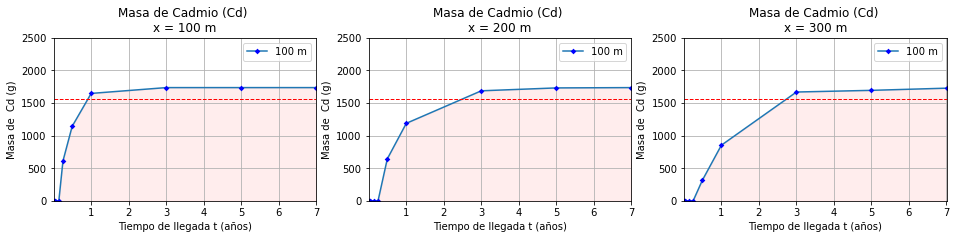

In [18]:
fig = plt.figure(figsize=(16,3))
for j in range (0,3):
    ax = fig.add_subplot(1, 3, j+1)
    b_1=0
    b_2=11
    plt.plot(times_y[b_1:b_2],a_0[j][b_1:b_2], label='100 m',marker="D", markersize="2", markeredgewidth="2",
             markerfacecolor="b", markeredgecolor="b")
    f_interp=InterpolatedUnivariateSpline(times_y[b_1:b_2],a_0[j][b_1:b_2],k=1)
    times1=np.linspace(times_y[b_1],times_y[b_1],250)
    t1=f_interp(times1)
    plt.plot(times1,t1)
    plt.axhline(t_ok[3]*.9, color='r', linestyle='dashed', linewidth=1)
    plt.fill_between(times_y[b_1:b_2], a_0[j][b_1:b_2],color='red', alpha=0.07)
    
    plt.title('Masa de Cadmio (Cd) \nx = {} m'.format((j+1)*100))
    plt.xlabel('Tiempo de llegada t (años)')
    plt.ylabel('Masa de  Cd (g)')
    plt.legend(loc=1)
    plt.grid()
    v=[times_y[b_1],times_y[b_2-1],p_900[b_1],2500]
    plt.axis(v)


    inverse_100= inversefunc(f_interp, y_values=(t_ok[3]*.9), domain=(times[0],times[12]), image=(times[0],times[14]))

   # print(inverse_100)
    #print(f_interp(inverse_100))

    
plt.show()

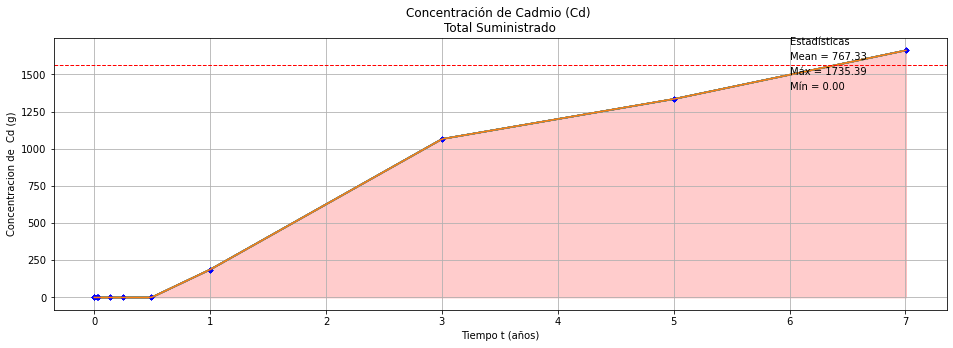

In [19]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
b_1=0
b_2=11
for i in range (0,11):
    plt.plot(times_y[b_1:b_2],p_900[b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
             markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,p_900,k=1)
times1=np.linspace(times_y[0],times_y[10],350)
t1=f_interp(times1)
plt.plot(times1,t1)
plt.fill_between(times1,t1,color='red', alpha=0.2)
plt.title('Concentración de Cadmio (Cd) \nTotal Suministrado')
plt.xlabel('Tiempo t (años)')
plt.ylabel('Concentracion de  Cd (g)')
plt.axhline(t_ok[3]*.9, color='r', linestyle='dashed', linewidth=1)
plt.grid()
a1=6
b1=1700
b2=100
plt.text(a1, b1,"Estadísticas",)
plt.text(a1, b1-b2, e[0])
plt.text(a1, b1-2*b2, e[1])
plt.text(a1, b1-3*b2, e[2])

plt.show()

In [20]:
f_interp=InterpolatedUnivariateSpline(times_y,p_900,k=1)
inverse_90= inversefunc(f_interp, y_values=(t[3]*.9), domain=(times[4],times[13]), image=(times[0],times[13]))
inverse_75= inversefunc(f_interp, y_values=(t[3]*.75), domain=(times[4],times[13]), image=(times[0],times[13]))
inverse_50= inversefunc(f_interp, y_values=(t[3]*.5), domain=(times[4],times[13]), image=(times[0],times[13]))
inverse_25= inversefunc(f_interp, y_values=(t[3]*.25), domain=(times[4],times[13]), image=(times[0],times[13]))  
print(inverse_90, inverse_75, inverse_50, inverse_25)
t[3]*.90

1193055199.944386 1195985161.5843885 1197498112.8124146 1187146918.4878974


1561.853782081604

In [21]:
print(inverse_90/(86400*365),
inverse_75/(86400*365),
inverse_50/(86400*365),
inverse_25/(86400*365))

37.831532215385145 37.924440689510035 37.97241605823233 37.64418183941836


6.39065887218541


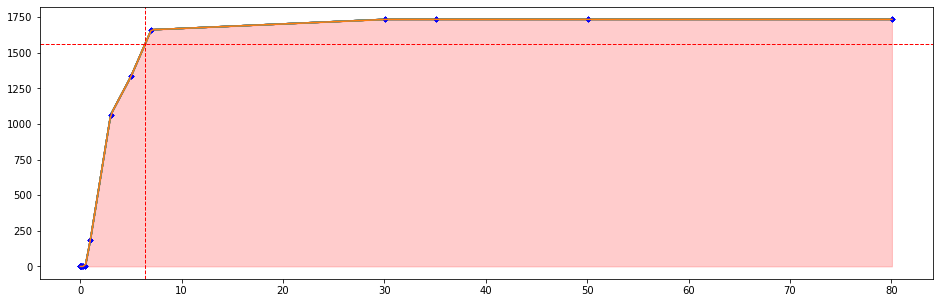

In [22]:

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
t_90=[]
b_1=0
b_2=15
z=94
for i in range (0,11):
    plt.plot(times_y[b_1:b_2],p_900[b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
             markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,p_900,k=1)
times1=np.linspace(times_y[0],times_y[14],300)
t1=f_interp(times1)
plt.plot(times1,t1)
plt.fill_between(times1,t1,color='red', alpha=0.2)
plt.axhline(t[3]*.9, color='r', linestyle='dashed', linewidth=1)

inverse_90= inversefunc(f_interp, y_values=(t[3]*.9),image=(times[0],times[13]))
plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)
print(inverse_90)

In [23]:
inverse_90/(86400*365)

2.0264646347619894e-07

In [24]:
Kriging=[]
Kriging.append(inverse_90)

In [25]:
Kriging

[array(6.39065887)]

In [26]:
#tiempos para que salga el 90% a distitnas distancias
0.91,2.56,2.76,2.84,4.32,4.66,5.12,6.33,6.5

(0.91, 2.56, 2.76, 2.84, 4.32, 4.66, 5.12, 6.33, 6.5)